In [1]:
## Imports

# utility modules
import glob
import os
import sys
import re

# the usual suspects:
import numpy as np
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj

# modules you'll need if you're downloading the data:
import icepyx as pyx
import shutil
import geopandas as gpd

# run matplotlib in 'widget' mode
%matplotlib widget
%load_ext autoreload
%autoreload 2

/home/ben/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Jessica's function for loading multiple data requests
#define function to loop through series of requests to get data

def multiple_is2_requests(earthdata_email, earthdata_uid, data_home, requests, subset, download):
    for req in requests:
        #### Download this data: (uncomment and run)
        print(req)
        region_a = pyx.Query(req['short_name'], req['spatial_extent'], req['date_range'])
        if download==True:
            region_a.earthdata_login(earthdata_uid, earthdata_email)
            region_a.download_granules(data_home,subset=subset)
        print(region_a.dataset)
        print(region_a.dates)
        print(region_a.start_time)
        print(region_a.end_time)
        print(region_a.dataset_version)
        print(region_a.spatial_extent)
        region_a.visualize_spatial_extent()

## A note on data
Since the hackweek is over, you'll need to download some ATL03 and ATL06 yourself put it somewhere sensible.  Mine is in /home/jovyan/tutorial-data, but you may need to edit this cell to match where you want to put the data.  The next cell contains the code to download the data from NSIDC.  It takes a while to run, so if you run the cell, this may be a good time to get a cup of coffee.

Unfortunately, due to space limitations, this notebook will not run on the binder instance.  You'll have to clone it to a local machine and run it there.

{'short_name': 'ATL06', 'spatial_extent': [-102, -76, -98, -74.5], 'date_range': ['2018-10-14', '2020-04-01']}
ATL06
['2018-10-14', '2020-04-01']
00:00:00
23:59:59
003
['bounding box', [-102, -76, -98, -74.5]]


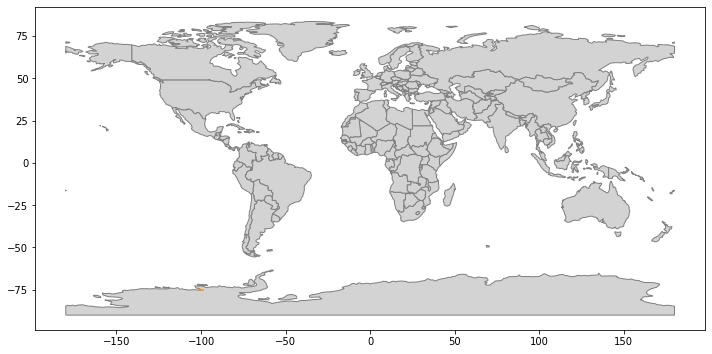

{'short_name': 'ATL03', 'spatial_extent': [-102, -76, -98, -74.5], 'date_range': ['2018-10-14', '2020-04-01']}
ATL03
['2018-10-14', '2020-04-01']
00:00:00
23:59:59
003
['bounding box', [-102, -76, -98, -74.5]]


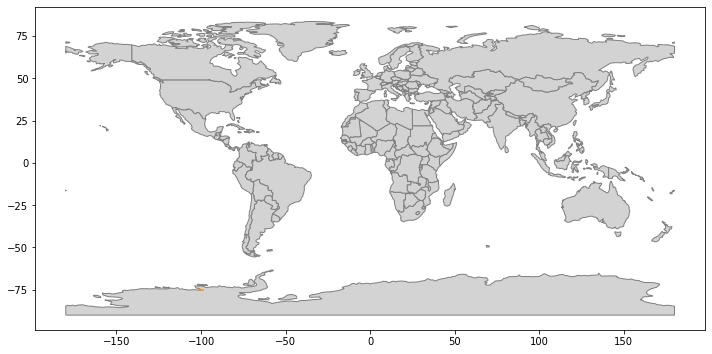

{'short_name': 'ATL03', 'spatial_extent': [-102, -76, -98, -74.5], 'date_range': ['2019-12-28', '2019-12-29']}
ATL03
['2019-12-28', '2019-12-29']
00:00:00
23:59:59
003
['bounding box', [-102, -76, -98, -74.5]]


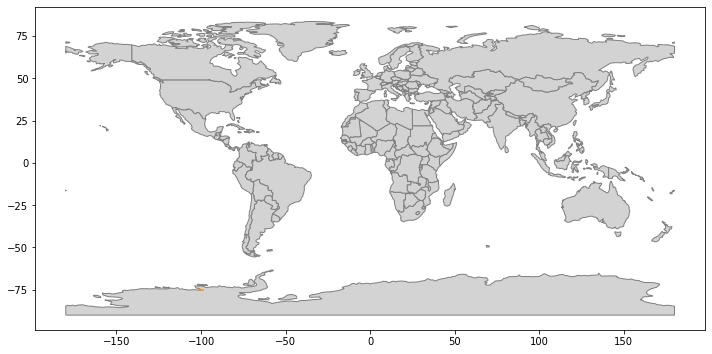

In [3]:
earthdata_email='your email here'
earthdata_name='your earthdata login'

data_root='/home/jovyan/tutorial-data'

#set DOWNLOAD to true if you're ready to download the data:
download=True
subset=True
    
requests=[
    {   'short_name' : 'ATL06',
        'spatial_extent' :[-102, -76, -98, -74.5],
        'date_range' : ['2018-10-14','2020-04-01']},
    {   'short_name' :'ATL03',
        'spatial_extent' :[-102, -76, -98, -74.5],
        'date_range' : ['2019-12-28', '2019-12-29']}]

multiple_is2_requests(earthdata_email, earthdata_uid, data_root, requests, subset, download);


# Land ice applications: Getting familiar with ICESat-2 products over land ice

## 1. Introduction
In this tutorial, we're going to take a first look at some of the ICESat-2 data over land ice.  We're going to demonstrate how ALT06 segments correspond to ATL03 photons, and demonstrate the repeat-track structure of ATL06 data. '

## 1.1 Learning goals
Our learning goals include understanding:
* how ice-sheet surfaces are represented by ATL03 photons
* how ATL06 elevations correpond to ATL03 photon clouds
* how small-scale features appear in ATL06
* the repeat structure of ATL06
* how cross-track slope can affect elevation differences
and we'll also give:
* a sneak peak at the ATL11 product.

## 1.2 Tools presented and developed:
Along the way, we'll present:
* A reader for ATL03
* A reader for ATL06
* Geographic projections with pyproj
* Filtering ATL06 elevations using slope and quality parameters
* Mapping surface elevations and profiles with matplotlib
* Visualizing ATL03 and ATL06 together.

### 1.2.1 Modules Used:
If you look at the first cell in the notebook, you can see that we're importing:
* h5py: a library to read (and write) hdf5 data
* pyproj: a library of geographic corrections

We'll also us my pointCollection package, which contains code to read a variety of datatypes, which we'll use to read image data and to take a first look at the ATL11 product.

In [5]:
try:
    import pointCollection as pc
except Exception:
    !python3 -m pip install --user git+https://github.com/smithb/pointCollection.git
    import pointCollection as pc

We'll also use Tyler Sutterley's excellent read_HDF5_ATL03 package (stored in the 'readers' directory, one level above the current directory.

In [6]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.get_ATL03_x_atc import get_ATL03_x_atc

### 1.2.2 Data used
In this tutorial, we'll use the ATL03 and ATL06 data that were downloaded in the top couple of cells.  You'll have put them in the data_root directory specified in those cells, and we'll look for our mosaic background image in the same location.

#### Image background

We'll also use an image mosaic as background for Antarcitca.  It's available in the shared space on jovyan in the MOA subdirectory

If you're running the script outside the hackweek.io world, you'll need to download the files from NSIDC.  I've posted a 1-km downscale of the raw (125-meter) mosaic, but the 750-meter mosaic here will do nicely:

https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009/geotiff/moa750_2009_hp1_v01.1.tif.gz

Try downloading the linked file (you'll need to log in to Earthdata to get it), then put it in the data_root directory on your home machine.

## 1.3 Geographic setting

Let's read the the Mosaic of Antarctica for the region around Pine Island Glacier.  The mosaic is in polar-stereographic coordinates, so we'll need to project the geographic coordinates of the box into that projection to decide what part of the mosaic to read.

[-76.  -74.5 -74.5 -76.  -76. ]
[ -98.  -98. -102. -102.  -98.]
{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676795.06911107, -1495776.3429068 ,  -351373.02039448,
        -213363.11039831]), 'origin': 'lower'}


Text(0.5, 1.0, 'Mosaic of Antarctica for Pine Island Glacier')

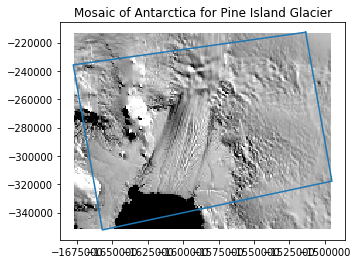

In [7]:
spatial_extent = np.array([-102, -76, -98, -74.5])
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]

### EDIT THIS PATH TO THE MOA LOCATION IF YOU NEED TO
MOA=pc.grid.data().from_geotif(os.path.join(data_root, 'moa_2009_1km.tif'), bounds=[XR, YR])

# show the mosaic:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
plt.plot(xy[0,:], xy[1,:])
plt.title('Mosaic of Antarctica for Pine Island Glacier')

This is the Pine Island Glacier.  It flows from the top of the map to the bottom (actually east to west, but it's rotated in the Polar Stereographic projection used here).  The striped area running from the middle of the page to the bottom is the Pine Island Ice Shelf, where the ice is floating.  We expect to see crevasses at the edges of the ice shelf (or really, anywhere in the ice shelf).  This area is often cloudy, so we expect to have trouble seeing the surface a lot of the time.


# 2. Data in along-track format

# 2.1 ATL03 elevations

Before we start looking at the ATL06 data we've downloaded, let's have a look at some of the ATL03 data that were used to make them.  One of the source ATL03 files is in the shared folder, and we'll read it with Tyler Sutterley's excellent "read_HDF5_ATL03" function.

In [8]:
# read the data:
rgt="0027"
cycle="06"
# read the IS2 data with Tyler's ATL03 reader:
ATL03_file=glob.glob(os.path.join(data_root, f'processed_ATL03_*{rgt}{cycle}*.h5'))[0]
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams =read_HDF5_ATL03(ATL03_file)

The data are returned in a set of dictionaries that mimic the structure of an ATL03 file.  To help visualize the data, we're going to calculate an along-track coordinate for every photon in the cloud (x_atc).  This is a slightly complex job, and there's a helper function in the readers directory that you can look at if you want the details.

In [9]:
# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)

### 2.1.1 Plotting ATL03 photons
Now let's plot the ATL03 photons.  We'll plot all the photon heights as small black dots, then plot the photons that the ATL03 land-ice signal finder designates as surface (with low, medium, or high confidence) in green.  

/home/ben/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


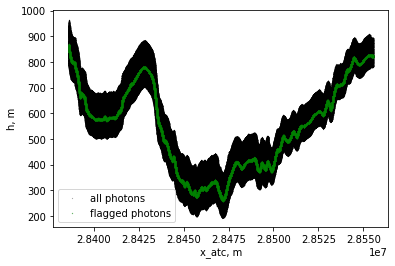

In [10]:
#-- select the 2l beam from ATL03
D3 = IS2_atl03_mds['gt2l']

#-- create scatter plot of photon data (e.g., photon elevation vs x_atc)
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.',markersize=0.25, label='all photons')
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
ax.plot(D3['heights']['x_atc'][LMH], D3['heights']['h_ph'][LMH],'g.',markersize=0.5, label='flagged photons')
h_leg=ax.legend()

ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()

What we see here is a fat black bar, representing all the photons that were close to the surface (in a ~200 m window), with a green line representing the photons flagged by ATL03 as representing the surface. If we zoom in (using the square button on the right) we can see that the black bar is made up of lots of individual photons, with a darker line that represents the surface.  

## 2.2 ATL06 elevations

ATL03 can show where the surface is, but it doesn't explicitly report a surface height.  It's also a bulky product that can be slow to load.  ATL06 reduces elevation data to a 20-meter posting, and gives one elevation per 20 meters (instead of hundreds in ATL03). 

### 2.2.1 simple ATL06 reader
To help work with ATL06 data, we'll use a simple piece of code that reads ATL06 data one beam at a time and stores it in a dictionary.  The code has a default set of fields to be read from an ATL06 file, and stores the data from each field in the output dictionary.  It also takes care of removing bad data, by setting values that are marked as invalid in the file to NaN.  It also uses hte 


In [11]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

We'll use this to read the ATL06 data that correspond to the ATL03 data in the previous cell, and will plot the ATL06 elevations on top of the ATL03 photons.

In [12]:
# find the matching ATL06 file
ATL06_file=glob.glob(os.path.join(data_root, f'processed_ATL06*{rgt}{cycle}*.h5'))[0]
D6=atl06_to_dict(ATL06_file,'/gt2l', index=None, epsg=3031)

# plot the elevations on top of the previous axes.  You should be able to scroll up to the previous plot and see the ATL06 points.
ax.plot(D6['x_atc'], D6['h_li'],'r.', label='ATL06')
ax.legend();

### 2.1.2 Cloudy tracks and singnal-finding blunders

Cycle 6 happened in pretty nice weather.  Not so much cycle 5.  Let's take a look at the ATL03 and the ATL06 for cycle 5 and see what happens when things don't go well for ICESat-2.

/Volumes/ice2/ben/hackweek_data/processed_ATL03_20190928165055_00270510_003_01.h5


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ben/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


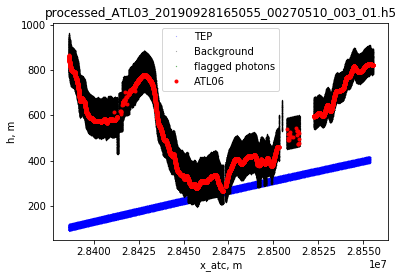

In [13]:
rgt="0027"
cycle="05"
beam='gt2r'

# read the IS2 data with Tyler's ATL03 reader:
ATL03_file=glob.glob(os.path.join(data_root, f'processed_ATL03*{rgt}{cycle}*.h5'))[0]
print(ATL03_file)
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams =read_HDF5_ATL03(ATL03_file)
# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)

#-- select the 2r beam from ATL03
D3 = IS2_atl03_mds[beam]

# find the matching ATL06 file
ATL06_file=glob.glob(os.path.join(data_root, f'processed_ATL06*{rgt}{cycle}*.h5'))[0]
D6=atl06_to_dict(ATL06_file, beam, index=None, epsg=3031)
#-- create scatter plot of photon data (e.g., photon elevation vs x_atc)
%matplotlib widget
f1,ax = plt.subplots(num=1,figsize=(6,4))
TEP=(D3['heights']['signal_conf_ph'][:,3] <-1)   
ax.plot(D3['heights']['x_atc'][TEP], D3['heights']['h_ph'][TEP],'b.',markersize=0.25, label='TEP')
BG=(D3['heights']['signal_conf_ph'][:,3] ==0)   |  (D3['heights']['signal_conf_ph'][:,3] ==1)
ax.plot(D3['heights']['x_atc'][BG], D3['heights']['h_ph'][BG],'k.',markersize=0.25, label='Background')
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
ax.plot(D3['heights']['x_atc'][LMH], D3['heights']['h_ph'][LMH],'g.',markersize=0.5, label='flagged photons')
ax.plot(D6['x_atc'], D6['h_li'],'r.', label='ATL06')
h_leg=ax.legend()

plt.title(os.path.basename(ATL03_file))

ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()

Now the window of photons around the surface is much more scattered, there are some places where ATL06 is reporting heights for something that's probably not the surface, and there's a stripe of extra photons below the surface that doesn't make any obvious sense.  The new (blue) stripe of photons is the TEP or Transmitter Echo Pulse, which records a packet of photons that are looped from the transmit to the receive side of ATLAS to help monitor its impulse response.  ATL06 ignores these photons, and we should too.  


### 2.1.3 Filtering out bad returns with ATL06_quality summary and with along-track differencing.

ATL06 "points" aren't just points, though.  They contain a variety of different flags that can help us filter out bad data.  Two of those that we can use are:

-- atl06_quality_summary : a flag that evaluates whether any problems have been found for a particular segment.  A 'zero' value indicates that the automatic filters haven't found anything wrong with the segment.
-- dh_fit_dx : The surface slope estimated for the segment in the along-track direction.  We can use this to check whether each segment is consistent with its neighbors.

Let's add two helper functions that we can use to try these ideas out.  

The first helper function plots the along-track slopes for each segment:

In [14]:
def plot_segs(D6, ind=None, **kwargs):
    """
    Plot a sloping line for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    #define the heights of the segment endpoints.  Leave a row of NaNs so that the endpoints don't get joined
    h_ep=np.zeros([3, D6['h_li'][ind].size])+np.NaN
    h_ep[0, :]=D6['h_li'][ind]-D6['dh_fit_dx'][ind]*20
    h_ep[1, :]=D6['h_li'][ind]+D6['dh_fit_dx'][ind]*20
    # define the x coordinates of the segment endpoints
    x_ep=np.zeros([3,D6['h_li'][ind].size])+np.NaN
    x_ep[0, :]=D6['x_atc'][ind]-20
    x_ep[1, :]=D6['x_atc'][ind]+20

    plt.plot(x_ep.T.ravel(), h_ep.T.ravel(), **kwargs)

The second helper function calculates how close the endpoints of each segment are to centerpoints of that segment's neighbors:

<img src="images/dh_segment_sm.jpg"  width=500 height=450>

If we look at the difference between $h_m$ - 20 dh_fit_dx and $h_{m-1}$ and at the difference between $h_m$ + 20 dh_fit_dx and $h_{m+1}$, we can get an idea of whether segments $m-1$, $m$, and $m+1$ are consistent.  We'll report the minimum of $|h_m - 20 dh\_fit\_dx - h_{m-1}|$ and $|h_m + 20 dh\_fit\_dx - h_{m+1}|$.  A small value indicates that a segment is consistent with at least one of its neighbors.

In [15]:
def min_seg_difference(D6):
    """
    seg_difference_filter: Use elevations and slopes to find bad ATL06 segments
    
    
    Inputs: 
        D6: a granule of ATL06 data, in dictionary format.  Must have entries:
            x_atc, h_li, dh_fit_dx
        
    Returns:
        delta_h_seg: the minimum absolute difference between each segment's endpoints and those of its two neighbors
    """
    h_ep=np.zeros([2, D6['h_li'].size])+np.NaN
    h_ep[0, :]=D6['h_li']-D6['dh_fit_dx']*20
    h_ep[1, :]=D6['h_li']+D6['dh_fit_dx']*20
    delta_h_seg=np.zeros_like(D6['h_li'])
    delta_h_seg[1:]=np.abs(D6['h_li'][1:]-h_ep[1, :-1])
    delta_h_seg[:-1]=np.minimum(delta_h_seg[:-1], np.abs(D6['h_li'][:-1]-h_ep[0, 1:]))
    return delta_h_seg


Let's see how each of these helps find bad data:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ben/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


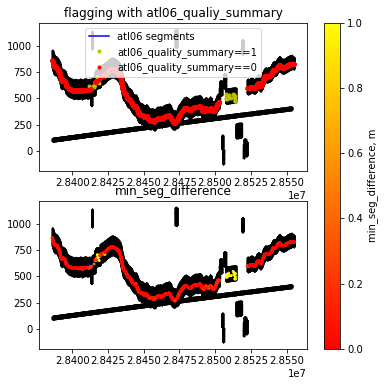

In [16]:
fig=plt.figure(figsize=[6, 6])
h1=fig.add_subplot(211)
plt.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.', markersize=0.25)
# plot the segments:
plot_segs(D6, color='b', label='atl06 segments')
good=D6['atl06_quality_summary']==0
#plot the bad-flagged points
plt.plot(D6['x_atc'][~good], D6['h_li'][~good],'y.', label='atl06_quality_summary==1')
plt.plot(D6['x_atc'][good],  D6['h_li'][good],'r.', label='atl06_quality_summary==0')
plt.legend()
plt.title('flagging with atl06_qualiy_summary')

h2=fig.add_subplot(212, sharex=h1, sharey=h1)
delta_h_seg=min_seg_difference(D6)
plt.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.', markersize=0.25, zorder=1)
plot_segs(D6, color='b', label='atl06 segments', zorder=2)
cm=plt.scatter(D6['x_atc'], D6['h_li'], 4, c=delta_h_seg, vmin=0, vmax=1, cmap='autumn', zorder=3); 
plt.colorbar(cm, ax=[h1, h2],label='min_seg_difference, m')
plt.title('min_seg_difference');


Selecting segments with atl06_quality_summary==0 or selecting segments with min_seg_difference < 1 is a good way to remove bad points from a plot like this, and combining the two can reduce the blunder rate further.  We'll use the summary flag in this tutorial, but keep both in mind!

# 3. Repeat track data from ATL06
Next, let's look at the big picture, combining data from multiple tracks around Pine Island Glacier.  We'll use the projected coordinates and plot on top of the image mosaic.

First, we'll every 25th point from one of the center-beam pairs for all files in our data directory.  We'll print an error if the reading fails, but will let the code continue anyway:

In [18]:
# find all the files in the directory:
ATL06_files=glob.glob(os.path.join(data_root, 'processed_ATL06*.h5'))
D_dict={}
error_count=0
for file in ATL06_files:
    try:
        D_dict[file]=atl06_to_dict(file, '/gt2l', index=slice(0, -1, 25), epsg=3031)
    except KeyError as e:
        print(f'file {file} encountered error {e}')
        error_count += 1
print(f"read {len(D_dict)} data files of which {error_count} gave errors")

file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20190502235902_05300310_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20200401080204_00880710_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20200122111503_04080610_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20200303092602_10330610_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20190822074451_08430412_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20190404012305_00880310_003_01.h5 encountered error 'Unable to open object (component not found)'
file /Volumes/ice2/ben/hackweek_data/processed_ATL06_20190711204548_02100410_003_01.h5 encount

About 20 of the files had problems, likely because clouds obscured the surface for gt2l.  That's too bad, but we can still work with the data we have. 

## 3.1. Repeat structure by cycle

Let's map the ground tracks for cycles 1 and 2 (not on repeat tracks) and for cycles 3 and later (measured on the repeat tracks).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676795.06911107, -1495776.3429068 ,  -351373.02039448,
        -213363.11039831]), 'origin': 'lower'}
{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676795.06911107, -1495776.3429068 ,  -351373.02039448,
        -213363.11039831]), 'origin': 'lower'}


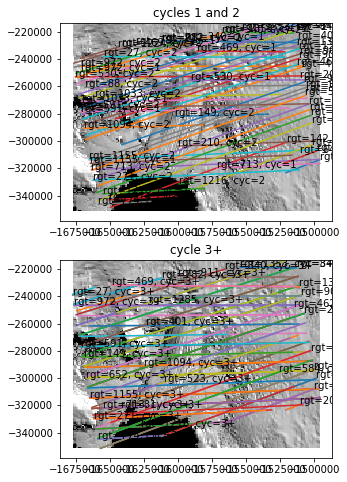

In [19]:
plt.figure(figsize=[8,8])
hax0=plt.gcf().add_subplot(211, aspect='equal')
MOA.show(ax=hax0, cmap='gray', clim=[14000, 17000]);
hax1=plt.gcf().add_subplot(212, aspect='equal', sharex=hax0, sharey=hax0)
MOA.show(ax=hax1, cmap='gray', clim=[14000, 17000]);
for fname, Di in D_dict.items():
    cycle=Di['cycle']
    if cycle <= 2:
        ax=hax0
    else:
        ax=hax1
    #print(fname)
    #print(f'\t{rgt}, {cycle}, {region}')
    ax.plot(Di['x'], Di['y'])
    if True:
        try:
            if cycle  < 3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}", clip_on=True)
            elif cycle==3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}+", clip_on=True)
        except IndexError:
            pass
hax0.set_title('cycles 1 and 2');
hax1.set_title('cycle 3+');

Notice that cycles 1 and 2 were not precicely repeated, but all data from cycles 3 and onwards follow an exact set of repeats.  We've labeled the start of each track.  In this area, ascending tracks are labeled on the right (true South) side of the plot, while descending tracks are labeled on the left (true North) side.

## 3.2 A map-view look at elevations
Now let's map the elevations associated with these plots.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676795.06911107, -1495776.3429068 ,  -351373.02039448,
        -213363.11039831]), 'origin': 'lower'}


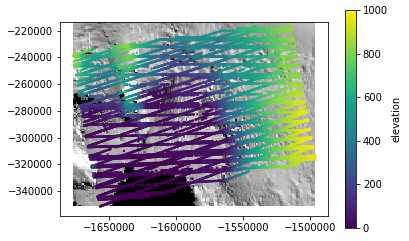

In [20]:
map_fig=plt.figure()
map_ax=map_fig.add_subplot(111)
MOA.show(ax=map_ax, cmap='gray', clim=[14000, 17000])
for fname, Di in D_dict.items():
    # select elevations with good quality_summary
    good=Di['atl06_quality_summary']==0
    ms=map_ax.scatter( Di['x'][good], Di['y'][good],  2, c=Di['h_li'][good], \
                  vmin=0, vmax=1000, label=fname)
map_ax._aspect='equal'
plt.colorbar(ms, label='elevation');


Elevations run from low (blue) on the ice shelf, to high (yellow) on the surrounding ridges. There are a few elevation blunders here, but nothing to cry about, and most of the tracks seem to have fairly good coverage.

## 3.3 Plotting a repeat-track elevation profile
Next, let's plot a single profile for the black line in the figure above.  We'll plot the surface height (h_li) as a function of the along-track coordinate, x_atc.  Since when we read in the elevations to make the survey plot we only read every 100th elevation, we'll reread the data at full resolution before plotting it:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

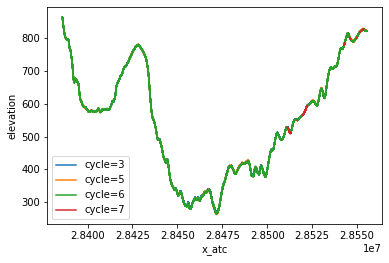

In [22]:
D_2l={}
D_2r={}

# specify the rgt here:
rgt="0027"
# iterate over the repeat cycles
for cycle in ['03','04','05','06','07']:
    for filename in glob.glob(os.path.join(data_root, f'processed_ATL06_*_{rgt}{cycle}*_003*.h5')):
        try:
            # read the left-beam data
            D_2l[filename]=atl06_to_dict(filename,'/gt2l', index=None, epsg=3031)
            # read the right-beam data
            D_2r[filename]=atl06_to_dict(filename,'/gt2r', index=None, epsg=3031)
            # plot the locations in the previous plot
            map_ax.plot(D_2r[filename]['x'], D_2r[filename]['y'],'k');  
            map_ax.plot(D_2l[filename]['x'], D_2l[filename]['y'],'k');
        except Exception as e:
            print(f'filename={filename}, exception={e}')

plt.figure();
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_segs(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
    
plt.legend()
plt.xlabel('x_atc')
plt.ylabel('elevation');

We see here that we have elevations from cycles 3, 5, and 6, but cycle 4 is missing.  That's likely because of clouds, and it's a fact of life in places where glaciers are found.

# BREAKOUT: [15 minutes of participant work]

We're going to move into breakout rooms for a few minutes.  Introduce yourselves, then take a look at the ATL03 data and at the ATL06 data.

1. Take some time to explore the PIG ATL03 data set.  There are two repeat measurements of the same rgt from two different cycles.  We have looked at one beam from each, but you can explore the different beams (strong and weak) and the different pairs (1, 2, and 3.)  Combine the first cell from 2.1.2 with the second cell from 2.1.3 to find examples where:

- ATL03 didn't capture the surface
- ATL06 is locked on something that's not the surface
- The quality-summary filtering strategy didn't work well

Please find at least one example of each, and post a screen grab in the #questions channel

2. Explore the ATL06 dataset.  The maps in 3.2 show where each track in the data set covers.  You can change the track number in the cell from 3.3, and can use the zoom button to look at different areas of each plot.  Also try looking at different beams (we've mapped only the center pair, but the other two pairs are there as well!)

Within your breakout rooms, work together to look at tracks from different parts of the dataset:
- inland ice (the sides of the ice stream)
- Ice-stream margins with crevasses (found at the edges of the ice stream)
- Ridged ice-shelf terrain (roughly the bottom third of the map)
- Rifts (cracks within the ice shelf)
- Data collected over sea ice

Again, post an example to the slack channel, and feel free to post anything else of intrest that you find!


## 3.4 an repeat-track example with substantial cross-track slope
Let's have a look at one of the tracks (rgt 652).  This time we're going to plot both the left and right beams in the central beam pair.  We'll plot the left beam with a dot and the right beam with plus.

/Volumes/ice2/ben/hackweek_data/processed_ATL06_20190429000723_04690310_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20191027152659_04690510_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20200126110645_04690610_003_01.h5


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676795.06911107, -1495776.3429068 ,  -351373.02039448,
        -213363.11039831]), 'origin': 'lower'}
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20190429000723_04690310_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20191027152659_04690510_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20200126110645_04690610_003_01.h5


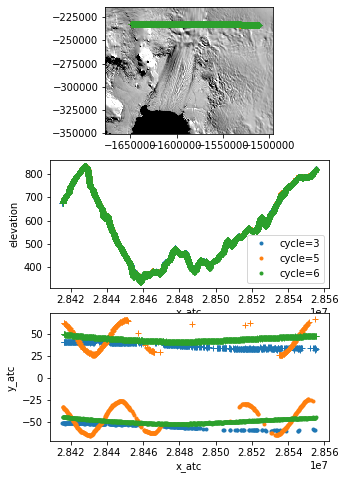

In [23]:
D_2l={}
D_2r={}

# specify the rgt here:
rgt="0469"
for cycle in ['03','04','05','06','07']:
    for filename in glob.glob(os.path.join(data_root, f'processed_ATL06_*_{rgt}{cycle}*_003*.h5')):
        print(filename)
        try:
            # read the left-beam data
            D_2l[filename]=atl06_to_dict(filename,'/gt2l', index=None, epsg=3031)
            # read the right-beam data
            D_2r[filename]=atl06_to_dict(filename,'/gt2r', index=None, epsg=3031)
        except Exception as e:
            print(f'filename={filename}, exception={e}')

plt.figure(figsize=[5, 8]);
ax1=plt.subplot(311)
MOA.show(cmap='gray', clim=[14000, 17000])
ax2=plt.subplot(312)
ax3=plt.subplot(313, sharex=ax2)
for filename, Dl in D_2l.items():
    print(filename)
    good=Dl['atl06_quality_summary']==0
    hl=ax2.plot(Dl['x_atc'][good], Dl['h_li'][good],'.', label=f"cycle={Dl['cycle']}")
    ax1.plot(Dl['x'][::10], Dl['y'][::10], '.', color=hl[0]._color)
    Dr=D_2r[filename]
    good=Dr['atl06_quality_summary']==0
    ax2.plot(Dr['x_atc'][good], Dr['h_li'][good],'+', color=hl[0]._color)
    ax1.plot(Dr['x'][::10], Dr['y'][::10], '+', color=hl[0]._color)
    
    ax3.plot(Dr['x_atc'][::10], Dr['y_atc'][::10],'.', color=hl[0]._color)
    ax3.plot(Dl['x_atc'][::10], Dl['y_atc'][::10],'+', color=hl[0]._color)
    
ax2.legend()
for ax in [ax2, ax3]:
    ax.set_xlabel('x_atc')    
ax2.set_ylabel('elevation');
ax3.set_ylabel('y_atc');


We can see that cycles 3, 4, and 6 are misaligned from one another.  Zooming , we can see that the terrain is higher to the left (plusses) than to the left.  This is very likely biasing the apparent elevation differences.  
# 3.5.1 : Correcting repeat elevations for cross-track slope

The ATL11 product will soon be available to sort this out, but in the meantime, we can do a basic correction using the across-track slope estimate in ATL06.  Since this is a middle pair, we should be able to use the slope to correct both beams' elevations to y_atc=0.  If it were left or a right pair, we'd correct it back to + or - 3200 m.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Volumes/ice2/ben/hackweek_data/processed_ATL06_20190429000723_04690310_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20191027152659_04690510_003_01.h5
/Volumes/ice2/ben/hackweek_data/processed_ATL06_20200126110645_04690610_003_01.h5


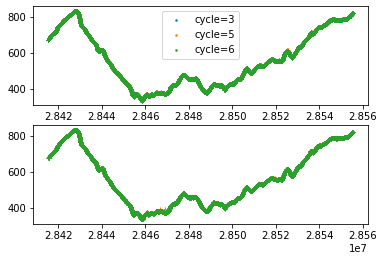

In [24]:
fig=plt.figure()
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212, sharex=ax1, sharey=ax1)
color_dict={}
for filename, Dl in D_2l.items():
    print(filename)
    good=Dl['atl06_quality_summary']==0
    Dr=D_2r[filename]

    hl=ax1.plot(Dl['x_atc'][good], Dl['h_li'][good],'.', markersize=3, label=f"cycle={Dl['cycle']}")
    # save the color for this cycle so we can use it again
    color_dict[int(Dl['cycle'])]=hl[0]._color
    atc_corr=Dl['y_atc']*Dl['dh_fit_dy']
    ax2.plot(Dl['x_atc'][good], Dl['h_li'][good]-atc_corr[good], '.', markersize=3,color=color_dict[int(Dl['cycle'])])
    
    good=Dr['atl06_quality_summary']==0
    ax1.plot(Dr['x_atc'][good], Dr['h_li'][good], '+', markersize=4, color=color_dict[int(Dl['cycle'])])
    atc_corr=Dr['y_atc']*Dr['dh_fit_dy']
    ax2.plot(Dr['x_atc'][good], Dr['h_li'][good]-atc_corr[good], '+', markersize=4, color=color_dict[int(Dl['cycle'])])
 
ax1.legend()

The elevations from each cycle now lie directly on top of each other.  Note that there are far fewer elevations from cycle 3, because the dh_fit_dy variable is only available when both beams in a pair have good-quality elevations (based on atl06_quality summary).  